In [6]:
import numpy as np
import pandas as pd
import rwi

In [691]:
def momentum_strategy(ts, period, type_ret):
    
    ts['returns'] = ts[['Close']].pct_change(period).fillna(0)
    ts['returns2'] = ts[['Close']].pct_change(period).fillna(0).shift(period).fillna(0)
    
    ts['entry'] = np.sign(ts['returns'] * ts.returns2) # signal
    #ts['entry'] = ts['entry'].shift(1).fillna(0)
    ts['direction'] = np.sign(ts.returns) # signal up, down
    ts['shift_returns'] = ts.returns.shift(-1).fillna(0)
    ts['shift_Change'] = ts['Change'].shift(-1).fillna(0)
    if type_ret == 1:
        ts['val'] = ts.shift_returns * ts.direction
    else:
        ts['val'] = ts.shift_Change * ts.direction
    return ts #ts[(ts.entry==1) & (ts.val > 0) ].val.sum() / (ts[(ts.entry==1) & (ts.val < 0) ].val.abs().sum())  #.dropna()

def mean_reversal(ts, period, type_ret):
    
    ts['returns'] = ts[['Close']].pct_change(period).fillna(0)
    ts['returns2'] = ts[['Close']].pct_change(period).fillna(0).shift(period).fillna(0)
    
    ts['entry'] = np.sign(ts['returns'] * ts.returns2) * (-1) # signal
    #ts['entry'] = ts['entry'].shift(1).fillna(0)
    ts['direction'] = np.sign(ts.returns * (-1)) # signal up, down
    ts['shift_returns'] = ts.returns.shift(-1).fillna(0)
    ts['shift_Change'] = ts['Change'].shift(-1).fillna(0)
    ts['val'] = ts.shift_returns * ts.direction
    if type_ret == 1:
        ts['val'] = ts.shift_returns * ts.direction - (0.03/100.0)
    else:
        ts['val'] = ts.shift_Change * ts.direction  - (0.03/100.0)
    return ts #ts[(ts.entry==1) & (ts.val > 0) ].val.sum() / (ts[(ts.entry==1) & (ts.val < 0) ].val.abs().sum())  #.dropna()


def mean_reversal2(ts, period, type_ret):
    
    ts['returns'] = ts[['Close']].pct_change(period).fillna(0)
    ts['returns2'] = ts[['Close']].pct_change(period).fillna(0).shift(period).fillna(0)
    
    ts['entry'] = np.sign(ts['returns'] * ts.returns2)  # signal
    #ts['entry'] = ts['entry'].shift(1).fillna(0)
    ts['direction'] = np.sign(ts.returns * (-1)) # signal up, down
    ts['shift_returns'] = ts.returns.shift(-1).fillna(0)
    ts['shift_Change'] = ts['Change'].shift(-1).fillna(0)
    ts['val'] = ts.shift_returns * ts.direction
    if type_ret == 1:
        ts['val'] = ts.shift_returns * ts.direction
    else:
        ts['val'] = ts.shift_Change * ts.direction
    return ts #ts[(ts.entry==1) & (ts.val > 0) ].val.sum() / (ts[(ts.entry==1) & (ts.val < 0) ].val.abs().sum())  #.dropna()

def ma_crossover(df_, a, b):

    df_ = df_[['Close']]
    df_['returns'] = df_['Close'].pct_change().fillna(0)
    df_['shift_returns'] = df_['Close'].pct_change().shift(-1).fillna(0)
    df_['sma'] = df_['Close'].rolling(a).mean().fillna(0)
    df_['smb'] = df_['Close'].rolling(b).mean().fillna(0)
    df_['signal'] = np.sign(df_.sma-df_.smb).diff().fillna(0)
    df_['sig_up'] = df_['signal'].cumsum().apply(lambda x:x*(x>0))
    df_['sig_dwn'] = df_['signal'].cumsum().apply(lambda x:x*(x<0))
    df_['val'] = df_.returns * df_.sig_up + df_.returns * df_.sig_dwn
    df_['pnls'] = np.cumsum(df_.returns * df_.sig_up + df_.returns * df_.sig_dwn)
    
    return df_

In [692]:
def load_df(name):
    eurusd_df = pd.read_csv(name)
    eurusd_df = eurusd_df.rename(columns={'<TICKER>':'Ticker', '<DTYYYYMMDD>':'Date', '<TIME>':'Time', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'})
    eurusd_df[['Date']] = pd.to_datetime(eurusd_df['Date'].astype('str'), yearfirst=True)
    eurusd_df =eurusd_df.sort_values(by=['Date', 'Time'])
    eur_df = eurusd_df[['Date', 'Time', 'Close', 'Open', 'High', 'Low', 'Vol']].rename(columns={'Close':'Close'})
    eur_df['Change'] = eur_df['Close'].pct_change()
    eur_df.dropna(inplace=True)
    #eur_df = eur_df[eur_df.Date>'2020-01-01']
    #eur_df = eur_df.set_index('Date')
    return eur_df

In [734]:
name='../dataset/eurusd_fxcm/eurusd_60min.csv'
eur_df = load_df(name)
eur_df = eur_df.set_index('Date')
eur_df.drop(columns=['Time'], inplace=True)

In [735]:
eur_df['price'] = eur_df['Close']

In [736]:
eur_df = rwi.generate_features(eur_df)

In [748]:
df = mean_reversal2(eur_df, 1, 1).fillna(0)

In [749]:
df['atr_14'] = df.returns.rolling(14).std().fillna(0)
df['atr_50'] = df.returns.rolling(50).std().fillna(0)
df['atr_200'] = df.returns.rolling(200).std().fillna(0)

In [750]:
stats_list = ['mean', 'median', 'mean+std', 'mean+2std', 'midrange', 'mean-std', 'mean-2std']

In [751]:
op_list = ['above', 'below']

In [752]:
ind_list = ['ROC_2', 'ROC_3', 'ROC_5', 'ROC_20', 'ROC_50', 'ROC_100', 'ROC_200',  'ROC_500', 'abs_returns',  'atr_14', 'atr_50', 'atr_200']

In [753]:
import itertools
s=[ stats_list, op_list, ind_list ]
comb_lst = list(itertools.product(*s))

In [754]:
def thresh(df_, thresh_val):
    if thresh_val == 'mean':
        return df_.mean()
    
    elif thresh_val == 'median':
        return df_.median()
    
    elif thresh_val == 'mean+std':
        return df_.mean() + df_.std()
    
    elif thresh_val == 'mean+2std':
        return df_.mean() + 2.0 * df_.std()
    
    elif thresh_val == 'midrange':
        return (df_.max() + df_.min())/2.0
    
    elif thresh_val == 'mean-std':
        return df_.mean() -  df_.std()
    
    elif thresh_val == 'mean-2std':
        return df_.mean() -  2.0 * df_.std()
    
def operation(df_, op_, thresh_val):
    
    if op_ == 'above':
        return df_ > thresh(df_, thresh_val)
    elif op_ == 'below':
        return df_ < thresh(df_, thresh_val)

    else:
        return 1
    
plots_idx = {}

def evaluate(df_, cond, stat, op, ind):
    
    count = df_[(df_.entry==1) & cond ].reset_index().val.count()
    prop = df_[(df_.entry==1) & cond & (df.val > 0) ].val.count() / ( df[(df.entry==1) & cond & (df.val > 0) ].val.count() + df[(df.entry==1) & cond & (df.val < 0) ].val.count())
    total_ret = df_[(df_.entry==1) & cond ].reset_index().val.sum()
    sharpe_ratio = (252* df_[(df_.entry==1) & cond ].reset_index().val.mean()) / (df_[(df_.entry==1) & cond ].reset_index().val.std() * np.sqrt(252)) 
    profit_factor = df_[(df_.entry==1) & (cond) & (df_.val > 0)].val.sum() / df_[(df_.entry==1) & cond & (df_.val < 0)].val.abs().sum()
    
    max_drw = df_[(df_.entry==1) & cond ].reset_index().val.cumsum().min()
    max_rsk = df_[(df_.entry==1) & cond ].reset_index().val.min()
    volat = df_[(df_.entry==1) & cond ].reset_index().val.std() * np.sqrt(252)
    
    plots_idx[ind+'_'+stat+'_'+op] = df_[(df_.entry==1) & cond ].reset_index().val.cumsum()
    
    return (count, prop, total_ret, sharpe_ratio, profit_factor, max_drw, max_rsk, volat, ind, stat,  op)

def plot_perf(df_, cond):
    return df_[(df_.entry==1) & cond ].reset_index().val.cumsum().plot()

def driver(df_, comb_lst):
    results = []
    for stat, op, ind in comb_lst:
        
        

        cond = operation(df_[ind], op, stat)
        res = evaluate(df_, cond, stat, op, ind)
        
        results.append(res)
    return results


In [755]:
%timeit
res_df = pd.DataFrame(driver(df, comb_lst), columns=['count', 'prop', 'total_ret', 'sharpe_ratio', 'profit_factor', 'max_drw', 'max_rsk', 'volat', 'ind', 'stat', 'op'])

C:\Users\lexik\.conda\envs\quant\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lexik\.conda\envs\quant\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


In [756]:
res_df['graph'] = res_df['ind'] + '_' + res_df['stat'] + '_' + res_df['op']
res_df = res_df.replace([np.inf, -np.inf], np.nan)
res_df.dropna(inplace=True)
res_df = res_df[res_df['count'] > 200]

In [757]:
res_df.corr(method='spearman')

,count,prop,total_ret,sharpe_ratio,profit_factor,max_drw,max_rsk,volat
count,1.000000,0.035279,0.951935,0.152933,0.181962,-0.571331,-0.589409,-0.630673
prop,0.035279,1.000000,0.213458,0.624406,0.618324,0.306666,0.188615,-0.103565
total_ret,0.951935,0.213458,1.000000,0.349102,0.371869,-0.485131,-0.494623,-0.618801
sharpe_ratio,0.152933,0.624406,0.349102,1.000000,0.995677,0.175321,0.314511,-0.332161
profit_factor,0.181962,0.618324,0.371869,0.995677,1.000000,0.159212,0.307435,-0.359921
max_drw,-0.571331,0.306666,-0.485131,0.175321,0.159212,1.000000,0.540388,0.260520
max_rsk,-0.589409,0.188615,-0.494623,0.314511,0.307435,0.540388,1.000000,0.208126
volat,-0.630673,-0.103565,-0.618801,-0.332161,-0.359921,0.260520,0.208126,1.000000


In [758]:
res_df.sort_values(by='sharpe_ratio', ascending=False)

,count,prop,total_ret,sharpe_ratio,profit_factor,max_drw,max_rsk,volat,ind,stat,op,graph
162,591,0.546531,0.066623,1.165248,1.243613,-0.004211,-0.007805,0.024379,ROC_200,mean-2std,below,ROC_200_mean-2std_below
159,662,0.543807,0.060572,0.932197,1.191995,-0.023415,-0.011195,0.024735,ROC_20,mean-2std,below,ROC_20_mean-2std_below
160,669,0.537425,0.064742,0.929452,1.186939,-0.004251,-0.011195,0.026238,ROC_50,mean-2std,below,ROC_50_mean-2std_below
138,2643,0.537353,0.207320,0.877473,1.182473,-0.000928,-0.011195,0.022527,ROC_200,mean-std,below,ROC_200_mean-std_below
103,946,0.546227,0.072389,0.854936,1.178004,-0.027103,-0.010332,0.022555,ROC_500,midrange,above,ROC_500_midrange_above
...,...,...,...,...,...,...,...,...,...,...,...,...
157,871,0.509781,-0.000896,-0.009337,0.998247,-0.023940,-0.020240,0.027772,ROC_3,mean-2std,below,ROC_3_mean-2std_below
106,783,0.521739,-0.004248,-0.042146,0.992674,-0.032480,-0.011195,0.032436,atr_50,midrange,above,atr_50_midrange_above
133,2819,0.515853,-0.019364,-0.075123,0.986198,-0.052063,-0.020240,0.023043,ROC_3,mean-std,below,ROC_3_mean-std_below
83,1241,0.509724,-0.023694,-0.159666,0.972539,-0.069156,-0.011195,0.030134,atr_200,mean+2std,above,atr_200_mean+2std_above


In [707]:
res_df['count'].max()

371607

In [688]:
res_df['count'].min()

224

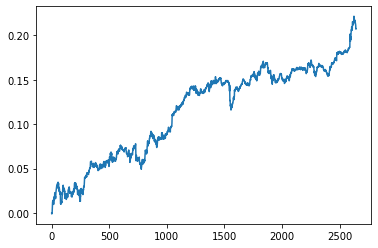

In [763]:
plots_idx['ROC_200_mean-std_below'].plot()

In [653]:
371607 * 0.2/100

743.214

In [669]:
1000* 0.2/100

2.0

In [646]:
60 * 371607

2229642

In [ ]:
30000 * 1.4

In [651]:
371607 * 20/100

74321.4

In [654]:
30000 * 1.4

42000.0

In [667]:
(0.3/1000)*100

0.03

In [624]:
sharpe_ratio = (252* df[(df.entry==1) ].reset_index().val.mean()) / (df[(df.entry==1)  ].reset_index().val.std() * np.sqrt(252)) 

In [558]:
sharpe_ratio

0.21449330736867364

In [559]:
profit_factor = df[(df.entry==1) & (df.val > 0)].val.sum() / df[(df.entry==1)  & (df.val < 0)].val.abs().sum()

In [560]:
profit_factor

1.043800360895987

In [561]:
df[(df.entry==1) ].reset_index().val.sum()

0.4937722642046586

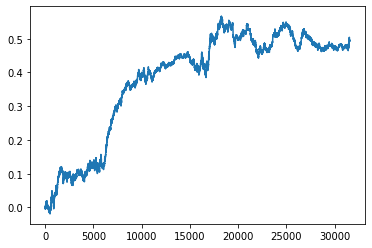

In [562]:
df[(df.entry==1) ].reset_index().val.cumsum().plot()

In [403]:
#### optimization using PCA-kmeans

In [414]:
res_df.groupby(['ind', 'op']).mean().sort_values(by=['sharpe_ratio', 'op'], ascending=False)

,,count,prop,total_ret,sharpe_ratio,profit_factor
ind,op,,,,,
ROC_500,below,1007.166667,0.490314,-0.017586,0.204380,1.041393
abs_returns,above,1082.000000,0.498335,-0.033106,0.069519,1.015598
atr_200,below,976.600000,0.501102,0.000719,0.059405,1.012402
ROC_20,below,1013.666667,0.503641,-0.058412,0.049636,1.013743
atr_14,above,888.000000,0.485180,-0.057909,0.007674,1.004607
atr_50,below,1049.600000,0.501437,-0.050014,-0.152260,0.973717
ROC_200,below,1209.800000,0.492342,-0.095968,-0.183202,0.968560
ROC_3,below,1186.000000,0.499404,-0.089628,-0.199208,0.965200
ROC_50,above,1051.500000,0.490261,-0.105015,-0.266631,0.954699


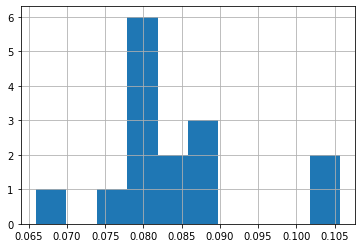

In [463]:
res_df[res_df['total_ret'] > 0]['volat'].hist()

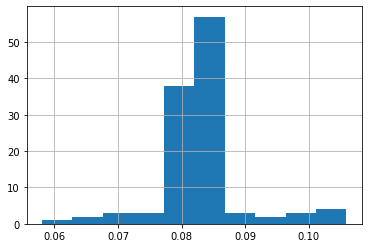

In [459]:
res_df.volat.hist()